In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt


In [9]:
work_path = '/content/gdrive/Shared drives/marketdata/stock/'
os.chdir(work_path)

### Define Parameters

In [10]:
STOP_PROFIT = 1
STOP_LOSS = 2
TIME_OUT = 3

In [11]:
def numtotime(num):
    ms = num % 1000
    num //= 1000
    s = num % 100
    num //= 100
    mi = num % 100
    num //= 100
    h = num % 100
    num = num // 100
    # print(h, mi, s, ms)
    return dt.datetime(2020, 9, 21, h, mi, s, ms) # TODO

# Hft_strategy

In [37]:
class Hft_strategy:
    def __init__(self, lob_file, tick_file):
        self.lob_file = open(lob_file)
        self.tick_file = open(tick_file)
        self.df = pd.read_csv(tick_file)
        self.df["time"] = self.df["time"].apply(func = numtotime)
        self.df.set_index("time", inplace = True)
        self.lob_col = self.lob_file.readline()[:-1].split(",")
        self.tick_col = self.tick_file.readline()[:-1].split(",")
        self.ref_num = 0
        self.num_buy = 0
        self.num_sell = 0
        self.ask1_p = 0
        self.ask2_p = 0
        self.ask3_p = 0
        self.ask4_p = 0
        self.ask5_p = 0
        self.ask1_q = 0
        self.ask2_q = 0
        self.ask3_q = 0
        self.ask4_q = 0
        self.ask5_q = 0
        self.bid1_p = 0
        self.bid2_p = 0
        self.bid3_p = 0
        self.bid4_p = 0
        self.bid5_p = 0
        self.bid1_q = 0
        self.bid2_q = 0
        self.bid3_q = 0
        self.bid4_q = 0
        self.bid5_q = 0
        self.daily_high = 0
        self.daily_low = 10000

        self.stop_profit = 0
        self.stop_loss = 0

        self.profit = 0
        self.cost = 0

        self.num_win = 0
        self.num_loss = 0

        self.order_time = 0
        self.stop_time = None

        self.position = []
        self.current_time = 0

        self.total_cost = 0

    def get_result(self):
        return self.profit, self.total_cost, self.num_win, self.num_loss

    def lob_update(self, lob_row):
        pass

    def tick_update(self, tick_row):
        pass

    def could_buy(self):
        pass

    def buy(self):
        pass

    def could_sell(self):
        pass

    def sell(self):
        pass

    def could_order(self):
        pass
        
    def order(self):
        pass

    def task(self):
        pass
    def show_result(self):
        pass

# YY5



In [58]:
class YY5(Hft_strategy):
    def __init__(self, lob_file, tick_file, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
        super().__init__(lob_file, tick_file)
        self.tick_list = []
        self.beta = beta
        self.time_out = time_out
        self.order_p = []
        self.gamma = gamma
        self.in_history = []
        self.out_history = []
        self.in_time = []
        self.out_time = []
        self.cool_down_min = cool_down_min
        self.stop_loss_factor = stop_loss_factor
        self.theta = theta
        self.weighted_p = 0
        self.total_trade_q = 0
        self.total_trade_p = 0
        self.position_max_q = position_max_q
        self.position = []

        print(self.lob_file)
        print(self.tick_file)


    def task(self):
        temp_lob = self.lob_file.readline()[:-1].split(",")
        temp_tick = self.tick_file.readline()[:-1].split(",")
        lob_row = pd.Series(data = temp_lob, index=self.lob_col)
        tick_row = pd.Series(data = temp_tick, index = self.tick_col)
        self.lob_datatype_conversion(lob_row)
        self.tick_datatype_conversion(tick_row)
        next_lob_time = lob_row['time']
        next_tick_time = tick_row['time']
        self.current_time = min(next_lob_time, next_tick_time)
        print(self.current_time)

        c = 0
        flag = 1
        while(self.current_time <= 130000000):
            # print(c)
            c += 1                        
            if (next_lob_time < next_tick_time):
                self.lob_update(lob_row)
                temp_lob = self.lob_file.readline()[:-1].split(",")
                lob_row = pd.Series(data = temp_lob, index=self.lob_col)
                self.lob_datatype_conversion(lob_row)
                next_lob_time = lob_row['time']
            else:
                self.tick_update(tick_row)
                temp_tick = self.tick_file.readline()[:-1].split(",")
                tick_row = pd.Series(data = temp_tick, index = self.tick_col)
                self.tick_datatype_conversion(tick_row)
                next_tick_time = tick_row['time']
            # print("next_lob: ", next_lob_time, "next_tick: ", next_tick_time)
            self.current_time = min(next_lob_time, next_tick_time)
            if self.could_sell():
                self.sell()
            if self.could_buy(tick_row):
                self.buy(tick_row)
            '''
            buy_type = self.could_buy(tick_row)
            if buy_type == STOP_PROFIT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.order_p)
                print("get", -self.order_p + self.cost)
                self.out_history.append(self.order_p)
                self.profit += self.cost - self.order_p 
                print("-"*30)
            elif buy_type == STOP_LOSS or buy_type == TIME_OUT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.ask1_p)
                print("get", -self.ask1_p + self.cost)
                self.out_history.append(self.ask1_p)
                self.profit += -self.ask1_p + self.cost
                print("-"*30)
            '''
        self.clear_position(tick_row)

    
    def lob_datatype_conversion(self, lob_row):
        lob_row['time'] = int(lob_row['time'])
        lob_row['ask1_price'] = float(lob_row['ask1_price'])
        lob_row['ask2_price'] = float(lob_row['ask2_price'])
        lob_row['ask3_price'] = float(lob_row['ask3_price'])
        lob_row['ask4_price'] = float(lob_row['ask4_price'])
        lob_row['ask5_price'] = float(lob_row['ask5_price'])
        lob_row['bid1_price'] = float(lob_row['bid1_price'])
        lob_row['bid2_price'] = float(lob_row['bid2_price'])
        lob_row['bid3_price'] = float(lob_row['bid3_price'])
        lob_row['bid4_price'] = float(lob_row['bid4_price'])
        lob_row['bid5_price'] = float(lob_row['bid5_price'])
        lob_row['ask1_qty'] = int(lob_row['ask1_qty'])
        lob_row['ask2_qty'] = int(lob_row['ask2_qty'])
        lob_row['ask3_qty'] = int(lob_row['ask3_qty'])
        lob_row['ask4_qty'] = int(lob_row['ask4_qty'])
        lob_row['ask5_qty'] = int(lob_row['ask5_qty'])
        lob_row['bid1_qty'] = int(lob_row['bid1_qty'])
        lob_row['bid2_qty'] = int(lob_row['bid2_qty'])
        lob_row['bid3_qty'] = int(lob_row['bid3_qty'])
        lob_row['bid4_qty'] = int(lob_row['bid4_qty'])
        lob_row['bid5_qty'] = int(lob_row['bid5_qty'])

    def tick_datatype_conversion(self, tick_row):
        tick_row['time'] = int(tick_row['time'])
        tick_row['price'] = float(tick_row['price'])
        tick_row['qty'] = int(tick_row['qty'])

    def lob_update(self, lob_row):
        self.ask1_p = lob_row['ask1_price'] 
        self.ask2_p = lob_row['ask2_price']
        self.ask3_p = lob_row['ask3_price']
        self.ask4_p = lob_row['ask4_price']
        self.ask5_p = lob_row['ask5_price']
        self.ask1_q = lob_row['ask1_qty']
        self.ask2_q = lob_row['ask2_qty']
        self.ask3_q = lob_row['ask3_qty']
        self.ask4_q = lob_row['ask4_qty']
        self.ask5_q = lob_row['ask5_qty']
        self.bid1_p = lob_row['bid1_price']
        self.bid2_p = lob_row['bid2_price']
        self.bid3_p = lob_row['bid3_price']
        self.bid4_p = lob_row['bid4_price']
        self.bid5_p = lob_row['bid5_price']
        self.bid1_q = lob_row['bid1_qty']
        self.bid2_q = lob_row['bid2_qty']
        self.bid3_q = lob_row['bid3_qty']
        self.bid4_q = lob_row['bid4_qty']
        self.bid5_q = lob_row['bid5_qty']

    def tick_update(self, tick_row):
        self.daily_low = min(self.daily_low, tick_row['price'])
        self.daily_high = max(self.daily_high, tick_row['price'])
        if self.current_time > 93000000:
            self.total_trade_q += tick_row['qty'] 
            self.total_trade_p += tick_row['price'] * tick_row['qty'] 
            self.weighted_p = self.total_trade_p / self.total_trade_q

        if (tick_row['price'] >= self.ask1_p):
            tick_row['buy_or_sell'] = "buy"
            self.num_buy += tick_row['qty'] 
        elif (tick_row['price'] <= self.bid1_p):
            tick_row['buy_or_sell'] = "sell"
            self.num_sell += tick_row['qty']
        else:
            tick_row['buy_or_sell'] = "QAO"
            print("------Weird price!!!!!---------")
            print("At time: ", tick_row['time'])
            print("tick_row_price", tick_row['price'])
            print("ask_1_p", self.ask1_p)
            print("bid_1_p", self.bid1_p)
            # assert(0), "Weird price!!!!!"

        if len(self.tick_list) < 10:
            self.tick_list.append(tick_row)
        else:
            if self.tick_list[0]['buy_or_sell'] == "buy":
                self.num_buy -= self.tick_list[0]['qty']
            elif self.tick_list[0]['buy_or_sell'] == "sell":
                self.num_sell -= self.tick_list[0]['qty']
            else:
                pass
            self.tick_list.pop(0)
            self.tick_list.append(tick_row)

    def could_sell(self):
        if self.bid1_p > self.weighted_p * self.theta \
            and self.current_time >= self.order_time + self.cool_down_min \
            and len(self.position) <= self.position_max_q:
            print("*** bid1_p: ", self.bid1_p)
            print("*** weighted_p: ", self.weighted_p)
            print("ask1_p: ", self.ask1_p)
            return True
        else:
            return False

    def sell(self):
        print("進場時間：", self.current_time, "\n  sell price at ", self.bid1_p)
        self.in_history.append(self.bid1_p)
        self.in_time.append(self.current_time)
        self.position = np.append(self.position, self.bid1_p)
        self.order_time = self.current_time
        self.cost = self.bid1_p
        self.order_p = np.append(self.order_p, self.bid2_p)

        self.total_cost += self.cost

    def could_buy(self, tick_row):
        # stop profit
        if len(self.position) and tick_row['price'] <= np.max(self.order_p):
            print("stop profit")
            return STOP_PROFIT
        # stop loss
        return False
        # elif len(self.position) and tick_row['price'] >= self.cost * self.stop_loss_factor:
        #     print("stop loss")
        #     return STOP_LOSS
        # # time out
        # elif len(self.position) and self.current_time - self.order_time >= self.time_out:
        #     print("time out")
        #     return False
        # else:
        #     return False
        # keep position

        # no position

    def buy(self, tick_row):
        print("出場時間：", self.current_time)
        self.out_history.append(tick_row['price'])
        self.out_time.append(self.current_time)
        print("POSITION(pre): ", self.position)
        print("Order_p(pre): ", self.order_p)
        print("tick_row price: ", tick_row['price'])
        buy_index = np.argwhere(self.order_p >= tick_row['price'])
        print("qualified index: ", buy_index)
        self.profit += (self.position-self.order_p)[buy_index].sum()
        self.position = np.delete(self.position, buy_index)
        self.order_p = np.delete(self.order_p, buy_index)
        print("POSITION(post): ", self.position)
        print("Order_p(post): ", self.order_p)
        print()

        # self.order_time = self.current_time
        
    def clear_position(self, tick_row):
        print("clear_position: ", np.sum(self.position-tick_row["price"]))
        print("position: ", self.position)
        self.profit += np.sum(self.position-tick_row["price"])
            

    def show_result(self):
        print("----------Result Report--------------")
        print("profit: ", self.profit)
        plt.subplot(211)
        plt.title("price")
        # plt.figure(figsize=(20,10))
        plt.scatter([numtotime(x) for x in self.in_time], self.in_history, marker='v', s= 144, c="red")
        plt.scatter([numtotime(x) for x in self.out_time], self.out_history, marker='^', s = 144, c="lime")
        plt.plot(self.df.index, self.df.loc[:, 'price'])
        plt.subplot(212)
        plt.title("qty")
        plt.plot(self.df.index, self.df.loc[:, "qty"])
        
        plt.show()



In [59]:
import datetime as dt



def back_test(start_date, end_date, sid):
    cur_day = None
    result_list = []
    for file in sorted(os.listdir()):
        if "zip" not in file:
            print(file)
            year, month, date = [int(x) for x in file.split("-")]

            cur_day = dt.datetime(year, month, date)
            if end_date >= cur_day >= start_date:
                sid_type = "otc"
                lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")

                if not os.path.exists(lob_path):
                    sid_type = "tse"
                    lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                    tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")
                    temp = YY5(lob_path, tick_path, 2, 2000000, 0.75, 100000, 1.02, theta=1.0025, position_max_q=10)
                    # beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q
                    temp.task()
                    result_list.append(temp.get_result())
                    temp.show_result()
    
    return result_list 

def calculate_profit(res_list):
    s = 0
    c = 0
    for x in res_list:
        s+=x[0]
        c+=x[1]
    return s, c


#### RUN

2020-07-01
2020-08-27
2020-09-21
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2330/tse_lob_2330.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2330/tse_tick_2330.csv' mode='r' encoding='UTF-8'>
90000651
*** bid1_p:  443.0
*** weighted_p:  0
ask1_p:  443.5
進場時間： 90000728 
  sell price at  443.0
stop profit
出場時間： 90005870
POSITION(pre):  [443.]
Order_p(pre):  [442.5]
tick_row price:  442.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  443.0
*** weighted_p:  0
ask1_p:  443.5
進場時間： 90100739 
  sell price at  443.0
*** bid1_p:  443.0
*** weighted_p:  0
ask1_p:  443.5
進場時間： 90200739 
  sell price at  443.0
*** bid1_p:  443.0
*** weighted_p:  0
ask1_p:  443.5
進場時間： 90301022 
  sell price at  443.0
------Weird price!!!!!---------
At time:  90328093
tick_row_price 443.5
ask_1_p 444.0
bid_1_p 443.0
*** bid1_p:  443.0
*** weighted_p:  0
ask1_p:  443.5
進場時間： 9040

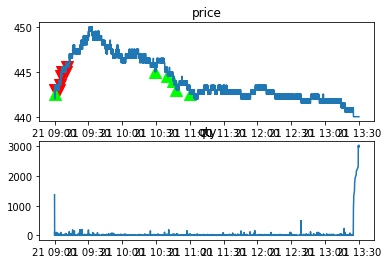

In [60]:
res_1301 = back_test(dt.datetime(2020, 9, 21), dt.datetime(2020, 9, 22), "2330")

In [55]:
profit_1301, cost_1301 = calculate_profit(res_1301)

In [56]:
profit_1301

6.0

In [57]:
cost_1301

5328.5